# 对象引用、可变性和垃圾回收

变量是标注，而不是盒子。

## 变量不是盒子

Python变量类似Java中的引用式变量，最好将它们理解为附加在对象上的标注。

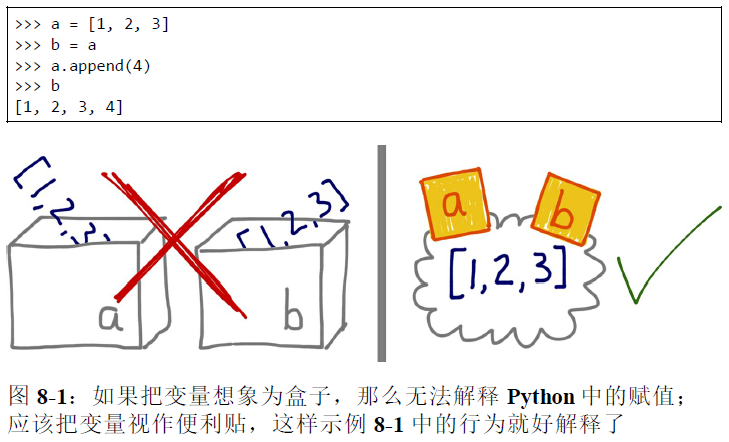

对于引用式变量来说，说把变量分配给对象更合理：Python中的赋值语句应该始终先读右边。

## 标识、相等性和别名

每个变量都有标识、类型和值。对象一旦创建，它的标识绝不会变；标识可以理解为对象在内存中的地址。

is运算符比较两个对象的标识；id()函数返回对象标识的整数表示。

==运算符比较两个对象的值（对象中保存的数据），而is比较对象的标识。

然而，变量和单例值之间的比较，应该使用is：``` X is None```  ```X is not None```

is运算符比==速度快，因为它不能重载，所以Python直接比较两个整数ID，而不用寻找并调用特殊方法。

a == b是语法糖，等同于a.\_\_eq\_\_(b)。object的eq方法比较对象ID，与is结果一样，但多数内置类型使用更有意义的方式覆盖了eq方法，会考虑对象属性的值。

### 元组的相对不可变性

元组与多数Python集合（列表，字典，集合等等）一样，保存的是对象的引用。

元组的不可变性指的是tuple数据结构的物理内容（保存的引用，各个元素的标识）不可变，与引用的对象无关。不能保证元素的值不改变。

## 默认做浅复制

复制列表（或多数内置的可变集合）最简单的方式是使用内置的类型构造方法。

然而，构造方法或[:]做的是浅复制（即复制了最外层容器，副本中的元素是源容器中元素的引用）。若有可变元素，可能会导致问题。

copy模块提供的deepcopy和copy函数能为任意对象做深复制和浅复制。

深复制不是件简单的事情，因为要考虑循环引用。deepcopy函数会记住已经复制的对象，因此能优雅地处理循环引用。

深复制有时可能太深了，对象可能引用不该复制的外部资源或单例值。我们可以实现```__copy__()```和```__deepcopy__()```来控制copy和deepcopy的行为。

## 函数的参数作为引用时

Python唯一支持的参数传递模式是共享传参(call by sharing):函数的各个形参获得实参中各个引用的副本--函数内的形参是实参的别名。

### 不要使用可变类型作为参数的默认值

默认值在定义函数时计算（通常在加载模块时），因此默认值变成了函数对象的属性。如果默认值是可变对象，会影响后续函数调用。

可变默认值导致的这个问题说明了为什么通常使用None作为接收可变值的参数的默认值。

### 防御可变参数

如果定义的函数接收可变参数，应该谨慎考虑调用方是否期望修改传入的参数。

除非方法确实想修改通过参数传入的对象，否则在类中直接把参数赋值给实例变量之前要三思，因为会为参数对象创建别名。若不确定，就应该创建副本。

## del和垃圾回收

对象绝不会自行销毁；然而，无法得到对象时，可能会被当做垃圾回收。

del语句删除名称，而不是对象。当且仅当del删除的变量保存的是对象最后一个引用，或者相互引用的一组对象无法被其他对象得到时，对象被当做垃圾回收。

## 弱引用

正是因为有引用，对象才会在内存中存在。但是，有时候需要引用对象，而不让对象存在的时间超过所需时间。这常用在缓存中。

弱引用不会增加对象的引用数量，故不会妨碍所指对象被当做垃圾回收。

weakref.ref类其实是低层借口，供高级用途使用。程序员最好使用weakref集合和finalize(内部使用弱引用)，而不是自己创建并处理weakref.ref实例。

In [ ]:
import weakref

a_set = {1, 2}
wref = weakref.ref(a_set)
print(wref)
print(wref())
a_set = {1, 2} # reassign a_set to a new tuple object
print(wref())
print(wref() is None)

WeakValueDictonary类实现一种可变映射，里面的值是对象的弱引用。被引用的对象在程序中其他地方被当做垃圾回收后，对应的键会自动从WeakValueDictionary中删除。因此，WeakValueDictionary经常用于缓存。

WeakKeyDictionary类里的键是对象的弱引用。可以为应用中其他部分拥有的对象附加数据，这样无需为对象添加属性。对覆盖属性访问权限的对象尤其有用。

WeakSet类保存元素弱引用的集合类，元素没有强引用时，集合会把它删除。可以用来保存一个类的所有实例的引用。

不是所有Python对象都可以作为弱引用的目标。基本的list和dict实例不能作为所指对象，但是他们的子类的实例可以。

set实例可以作为所指对象；int和tuple实例不能作为弱引用的目标，甚至它们的子类也不行。

这些限制来自于CPython内部的优化，不同的Python实现可能有差别。